In [1]:
# ======================================
# SENTIMENT ANALYSIS WITH NEURAL NETWORKS
# ======================================
# This program builds a neural network to classify text comments into 3 sentiment categories:
# 0 = Negative sentiment
# 1 = Neutral sentiment
# 2 = Positive sentiment

In [2]:
import json
import tensorflow as tf #building and training the NN

from tensorflow.keras.preprocessing.text import Tokenizer #text to numbers
from tensorflow.keras.preprocessing.sequence import pad_sequences #pad sequences to same length
from sklearn.model_selection import train_test_split #split training and testing data

import pandas as pd


In [3]:
vocab_size = 10000 #max number of unique words
embedding_dim = 16 #how many numbers rep each word
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>" #out of vocab words token
test_size = 0.2  # 20% for testing, 80% for training

from google.colab import files
uploaded = files.upload()

df = pd.read_csv("sentiment.csv")

Saving sentiment.csv to sentiment.csv


In [4]:
# Handle missing data
print(f"Missing comments before cleaning: {df['Comment'].isnull().sum()}")
df = df.dropna(subset=['Comment'])  # Remove rows with missing comments
print(f"Dataset shape after removing missing comments: {df.shape}")


Missing comments before cleaning: 217
Dataset shape after removing missing comments: (240928, 3)


In [5]:
# Check sentiment distribution
print("Sentiment distribution:")
print(df['Sentiment'].value_counts().sort_index())

Sentiment distribution:
Sentiment
0     55105
1     82777
2    103046
Name: count, dtype: int64


In [6]:
# Basic text preprocessing
df['Comment'] = df['Comment'].astype(str)  # Ensure all comments are strings
df['Comment'] = df['Comment'].str.lower()  # Convert to lowercase for consistency

In [7]:
#convert columns to python lists
comment = df['Comment'].tolist()
sentiment = df['Sentiment'].tolist()

In [8]:
# Properly split the data with randomization and stratification
training_comment, testing_comment, training_sentiment, testing_sentiment = train_test_split(
    comment,
    sentiment,
    test_size=test_size,
    random_state=42,  # for reproducibility
    stratify=sentiment  # maintains the same proportion of each class in both sets
)

print(f"Training samples: {len(training_comment)}")
print(f"Testing samples: {len(testing_comment)}")
print()

Training samples: 192742
Testing samples: 48186



In [9]:
#Tokenization - converting text to numbers

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_comment) #learn vocab from training data
word_index = tokenizer.word_index

print(f"Total unique words found: {len(word_index)}")
print(f"Using top {vocab_size} most common words")
print(f"Example word mappings: {dict(list(word_index.items())[:5])}")
print()

#text to seq of numbers
training_sequences = tokenizer.texts_to_sequences(training_comment)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_comment)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(f"Example: Original text: '{training_comment[0][:50]}...'")
print(f"         As numbers: {training_sequences[0][:10]}...")
print(f"         After padding: Shape {training_padded[0].shape}")
print()

Total unique words found: 138622
Using top 10000 most common words
Example word mappings: {'<OOV>': 1, 'modi': 2, 'india': 3, 'like': 4, 'people': 5}

Example: Original text: 'empty chairs meerut modi rally...'
         As numbers: [1532, 3805, 799, 2, 329]...
         After padding: Shape (100,)



In [10]:
# convert to numpy arrays for TensorFlow
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_sentiment)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_sentiment)


Building the neural network...
Architecture:
1. Embedding Layer: Converts word numbers to dense vectors
2. Global Average Pooling: Averages all word vectors into one vector
3. Dense Layer (24 neurons): Learns patterns with ReLU activation
4. Output Layer (3 neurons): Predicts probabilities for each sentiment class

In [33]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),

    # Dropout layer: randomly sets 30% of inputs to 0 during training to prevent overfitting
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(24, activation='relu'),

    # Another dropout layer: helps prevent overfitting in the dense layer
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(3, activation='softmax')  # 3 classes (0, 1, 2)
])
model.compile(loss='sparse_categorical_crossentropy', #multi class classification
              optimizer='adam', #efficient optimization algo
              metrics=['accuracy']) #track accuracy during training

# Build the model with the correct input shape to show proper summary
model.build(input_shape=(None, max_length))
model.summary()

# Early stopping: stops training when validation accuracy stops improving
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',    # Watch validation accuracy
    patience=5,                # Stop if no improvement for 5 epochs
    restore_best_weights=True, # Go back to best weights
    verbose=1                  # Print when stopping
)

num_epochs = 50  # Set higher since early stopping will prevent overfitting

history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=[early_stopping], verbose=2)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 100, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 24)             │           408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 24)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            75 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,483 (626.89 KB)

 Trainable params: 160,483 (626.89 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
6024/6024 - 21s - 4ms/step - accuracy: 0.5309 - loss: 0.9589 - val_accuracy: 0.6941 - val_loss: 0.7334
Epoch 2/50
6024/6024 - 17s - 3ms/step - accuracy: 0.7164 - loss: 0.7216 - val_accuracy: 0.7752 - val_loss: 0.6091
Epoch 3/50
6024/6024 - 16s - 3ms/step - accuracy: 0.7540 - loss: 0.6565 - val_accuracy: 0.7480 - val_loss: 0.6634
Epoch 4/50
6024/6024 - 18s - 3ms/step - accuracy: 0.7662 - loss: 0.6249 - val_accuracy: 0.8073 - val_loss: 0.5324
Epoch 5/50
6024/6024 - 18s - 3ms/step - accuracy: 0.7760 - loss: 0.6057 - val_accuracy: 0.7742 - val_loss: 0.5968
Epoch 6/50
6024/6024 - 23s - 4ms/step - accuracy: 0.7827 - loss: 0.5871 - val_accuracy: 0.7404 - val_loss: 0.6308
Epoch 7/50
6024/6024 - 21s - 3ms/step - accuracy: 0.7860 - loss: 0.5800 - val_accuracy: 0.8032 - val_loss: 0.5248
Epoch 8/50
6024/6024 - 16s - 3ms/step - accuracy: 0.7916 - loss: 0.5682 - val_accuracy: 0.8065 - val_loss: 0.5462
Epoch 9/50
6024/6024 - 15s - 3ms/step - accuracy: 0.7922 - loss: 0.5650 - val_accuracy: 

1. ACCURACY
- What it is: Percentage of predictions that are correct
- Range: 0.0 to 1.0 (0% to 100%)
- Example: accuracy: 0.7208 = 72.08% correct predictions
- Goal: Higher is better
2. LOSS
- What it is: How "confident" the model is when it's wrong
- Range: 0.0 to infinity (lower is better)
- Example: loss: 0.8670 = high error, loss: 0.3007 = low error
- Goal: Should decrease over time
3. VAL_ACCURACY (Validation Accuracy)
- What it is: Accuracy on the testing data (unseen data)
- Why important: This is the REAL performance measure
- Example: val_accuracy: 0.7208 = 72.08% correct on new data
- Goal: Should be close to training accuracy
4. VAL_LOSS (Validation Loss)
- What it is: Loss on the testing data (unseen data)
- Why important: Shows if model generalizes well
- Example: val_loss: 0.7023
- Goal: Should be close to training loss

In [34]:
print("\n=== TRAINING COMPLETED ===")
print(f"Final Training Accuracy: {history.history['accuracy'][-1]:.1%}")
print(f"Final Validation Accuracy: {history.history['val_accuracy'][-1]:.1%}")
print(f"Final Training Loss: {history.history['loss'][-1]:.4f}")
print(f"Final Validation Loss: {history.history['val_loss'][-1]:.4f}")

# Check for overfitting
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
accuracy_gap = train_acc - val_acc

print(f"\nAccuracy Gap (Train - Val): {accuracy_gap:.1%}")
if accuracy_gap > 0.05:  # 5% difference
    print("⚠️  Warning: Possible overfitting detected!")
    print("   The model may be memorizing training data rather than learning patterns.")
    print("   Consider: reducing epochs, adding regularization, or getting more data.")
elif accuracy_gap < -0.05:  # Validation much better than training
    print("🤔 Unusual: Validation accuracy higher than training accuracy.")
    print("   This can happen with small datasets or strong regularization.")
else:
    print("✅ Good: Training and validation accuracies are close!")
    print("   The model is learning well and generalizing to new data.")
print()


=== TRAINING COMPLETED ===
Final Training Accuracy: 80.0%
Final Validation Accuracy: 79.8%
Final Training Loss: 0.5433
Final Validation Loss: 0.5413

Accuracy Gap (Train - Val): 0.1%
✅ Good: Training and validation accuracies are close!
   The model is learning well and generalizing to new data.



Plotting accuracy - should generally increase over time


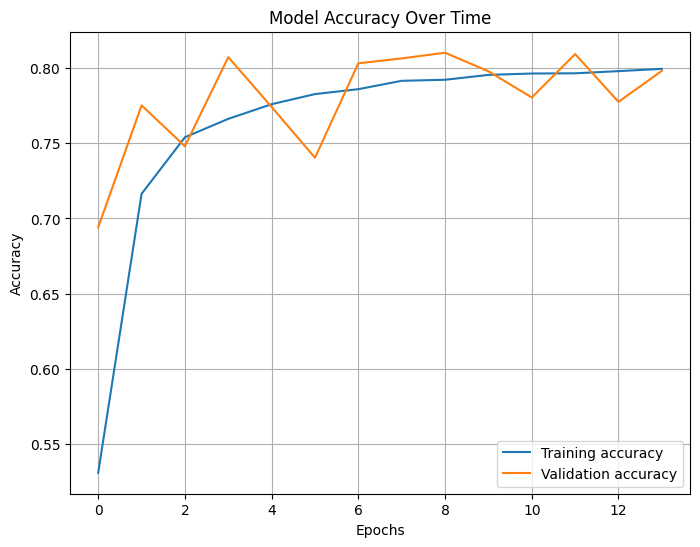

Plotting loss - should generally decrease over time


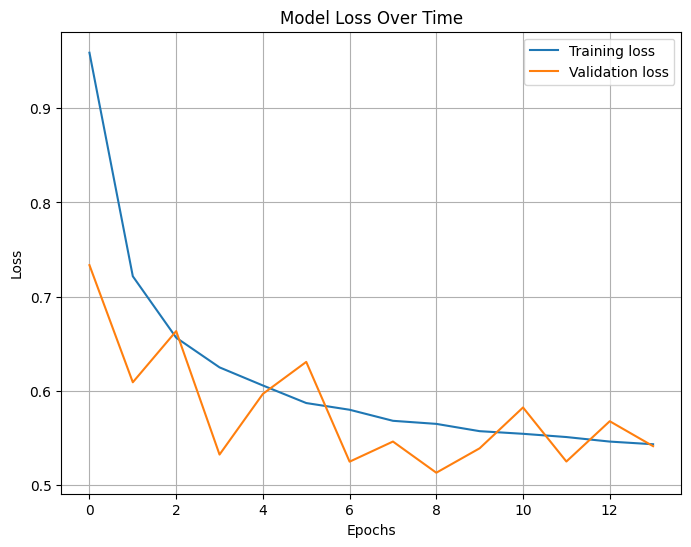

In [35]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
    """Plot training and validation metrics over time"""
    plt.figure(figsize=(8, 6))
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string.title())
    plt.title(f'Model {string.title()} Over Time')
    plt.legend([f'Training {string}', f'Validation {string}'])
    plt.grid(True)
    plt.show()

print("Plotting accuracy - should generally increase over time")
plot_graphs(history, "accuracy")

print("Plotting loss - should generally decrease over time")
plot_graphs(history, "loss")

In [36]:
#examine what the model learned

reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

def decode_sentence(text):
    """Convert a sequence of numbers back to words"""
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

print("Example of how the model sees text:")
print(f"Original: '{training_comment[2]}'")
print(f"As model sees it: '{decode_sentence(training_padded[0])}'")
print(f"True sentiment: {sentiment[2]} (0=Negative, 1=Neutral, 2=Positive)")
print()


Example of how the model sees text:
Original: 'thanks friends went watched movies ate chocolate chip pancakes one friends house fabulous'
As model sees it: 'empty chairs meerut modi rally ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ? ?'
True sentiment: 2 (0=Negative, 1=Neutral, 2=Positive)



In [37]:
# Get the embedding weights (how the model represents each word as numbers)
e = model.layers[0]  # First layer is the embedding layer
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)

import io

out_v = io.open('vecs.tsv', 'w', encoding='utf-8') #vector file
out_m = io.open('meta.tsv', 'w', encoding='utf-8') #metadata file

for word_num in range(1, vocab_size):
    try:
        word = reverse_word_index[word_num]
        embeddings = weights[word_num]
        out_m.write(word + "\n")
        out_v.write('\t'.join([str(x) for x in embeddings]) + "\n")
    except KeyError:
        continue  # Skip if word number doesn't exist

out_v.close()
out_m.close()

# try:
#   from google.colab import files
# except ImportError:
#   pass
# else:
#   files.download('vecs.tsv')
#   files.download('meta.tsv')

(10000, 16)


In [46]:
#trial sentences
sentence = ["Wow you are so beautiful i love you", "The trees are green like the grass", "I hate my life and all the horrible people in it"]

#convert to same format as training data
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [47]:
# Get predictions
print("=== MODEL PREDICTIONS ===")
predictions = model.predict(padded)
predicted_classes = np.argmax(predictions, axis=1)
print(f"\nRaw prediction probabilities:\n{predictions}")

# Explain the results
sentiment_labels = ['Negative', 'Neutral', 'Positive']

for i, sent in enumerate(sentence):
    print(f"\nSentence {i+1}: '{sent}'")
    print(f"Probabilities:")
    print(f"  Negative (0): {predictions[i][0]:.1%}")
    print(f"  Neutral (1):  {predictions[i][1]:.1%}")
    print(f"  Positive (2): {predictions[i][2]:.1%}")
    print(f"Predicted sentiment: {sentiment_labels[predicted_classes[i]]} (Class {predicted_classes[i]})")


=== MODEL PREDICTIONS ===
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step

Raw prediction probabilities:
[[1.8773457e-03 5.6732907e-03 9.9244940e-01]
 [3.6336374e-01 5.4384756e-01 9.2788756e-02]
 [9.9378514e-01 5.5697486e-03 6.4507022e-04]]

Sentence 1: 'Wow you are so beautiful i love you'
Probabilities:
  Negative (0): 0.2%
  Neutral (1):  0.6%
  Positive (2): 99.2%
Predicted sentiment: Positive (Class 2)

Sentence 2: 'The trees are green like the grass'
Probabilities:
  Negative (0): 36.3%
  Neutral (1):  54.4%
  Positive (2): 9.3%
Predicted sentiment: Neutral (Class 1)

Sentence 3: 'I hate my life and all the horrible people in it'
Probabilities:
  Negative (0): 99.4%
  Neutral (1):  0.6%
  Positive (2): 0.1%
Predicted sentiment: Negative (Class 0)


OVERFITTING FIXES IMPLEMENTED:
1. DROPOUT LAYERS

- Randomly "turns off" 30%/50% of neurons during training
- Forces the model to not rely on specific neurons
- Only active during training, not during prediction
- Result: Model becomes more robust and generalizes better

2. EARLY STOPPING

- Monitors validation accuracy every epoch
- If no improvement for 5 consecutive epochs → stops training
- Automatically restores the best weights found
- Result: Prevents training too long and overfitting